## Description

This notebook is an example for training a bi-directional LSTM to detect named entities in text.   

Author: Salvatore Salpietro

Date: Jan, 9 2021

### Import libraries

In [174]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# for padding sentences to the same length
from keras.preprocessing.sequence import pad_sequences

# for splitting into training/validation/test sets
from sklearn.model_selection import train_test_split

# for creating k-fold cross validation
# stratified tries to keep class balance between each fold
from sklearn.model_selection import StratifiedKFold, KFold

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
physical_devices = tf.config.list_physical_devices()
physical_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# tf.config.experimental.set_memory_growth(physical_devices[1], enable=True)

In [4]:
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "CPU") 
print('Device Spec: ', device_spec.to_string()) 

Device Spec:  /job:localhost/replica:0/device:CPU:*


### Load the data

Data is already tokenized and sentencized as well as lebeled.

Normally if you are starting from scratch you would need to first break the text into sentences, and then the sentences into tokens.  This requires creating or finding a good tokenizer and sentencizer for the task.  You may also need to include parts of speach tags which may help increase the accuracy of predictions. 

In [5]:
df = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [6]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [7]:
# fill NaN - propogate non null values forward
df = df.fillna(method="ffill")

In [8]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [9]:
# sentence count

sent_count = len(set(df["Sentence #"].values))
print(sent_count)

47959


In [10]:
# number of unique words

words = list(set(df["Word"].values))
words_count = len(words)
print(words_count)

35178


### Create index mappings for words and tags

This converts the tags and words into a numeric representation

In [11]:
# create word to index and index to word mappings
# word to index mapping
word2idx = {}
# add the padding and unknown token 
word2idx["PAD_TOKEN"] = len(word2idx)
word2idx["UNK_TOKEN"] = len(word2idx)

# add the rest
for i in range(0, len(words)):
    word2idx[words[i]] = len(word2idx)

# index to word mapping
idx2word = {i: w for w, i in word2idx.items()}

In [12]:
# number of unique tags

tags = list(set(df["Tag"].values))
tags_count = len(tags)
print(tags_count)

17


In [13]:
tags

['B-org',
 'B-gpe',
 'B-nat',
 'I-eve',
 'I-gpe',
 'O',
 'B-geo',
 'B-art',
 'I-tim',
 'I-nat',
 'B-per',
 'B-tim',
 'I-per',
 'I-org',
 'I-geo',
 'B-eve',
 'I-art']

In [14]:
# create index to tag and tag to index mappings
# tag to index mapping
tag2idx = {}

tag2idx['PAD_TAG'] = 0 # this is the tag that is assigned to the pad tokens 'PAD_TOKEN'
for i in range(0, len(tags)):
    tag2idx[tags[i]] = len(tag2idx)
    
# index to tag mapping
idx2tag = {i: w for w, i in tag2idx.items()}

In [15]:
idx2tag

{0: 'PAD_TAG',
 1: 'B-org',
 2: 'B-gpe',
 3: 'B-nat',
 4: 'I-eve',
 5: 'I-gpe',
 6: 'O',
 7: 'B-geo',
 8: 'B-art',
 9: 'I-tim',
 10: 'I-nat',
 11: 'B-per',
 12: 'B-tim',
 13: 'I-per',
 14: 'I-org',
 15: 'I-geo',
 16: 'B-eve',
 17: 'I-art'}

In [16]:
def getSentences(dataframe):
    
    sentences = []
    
    groups = dataframe.groupby("Sentence #")
    for name, group in groups:
        zipped = zip(group["Word"], group["Tag"])
        sentences.append(list(zipped))
        
    return sentences

In [17]:
sents = getSentences(df)

In [18]:
len(sents[0]), len(sents[1]) # sentences are of different lengths

(24, 25)

In [19]:
sents[100]

[('She', 'O'),
 ('was', 'O'),
 ('a', 'O'),
 ('longtime', 'O'),
 ('member', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('Zapatista', 'B-geo'),
 ('movement', 'O'),
 ('and', 'O'),
 ('appeared', 'O'),
 ('in', 'O'),
 ('public', 'O'),
 ('wearing', 'O'),
 ('a', 'O'),
 ('black', 'O'),
 ('ski', 'O'),
 ('mask', 'O'),
 ('.', 'O')]

### Padding

Pad / truncate the sentences, all to the same length

In [20]:
# choose a max length for each sentence
# sentences will be padded / truncated to this length

max_len = 128

In [21]:
# first convert the tokens and tags to index
# word 1 is the label
y = [[tag2idx[word[1]] for word in s] for s in sents]

In [22]:
y

[[6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6],
 [2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 12, 6, 6, 6, 1, 6, 6, 6, 6, 6],
 [6,
  6,
  12,
  6,
  6,
  6,
  6,
  6,
  7,
  6,
  6,
  6,
  6,
  6,
  1,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  15,
  6],
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 [7,
  6,
  6,
  11,
  13,
  6,
  12,
  6,
  7,
  6,
  2,
  6,
  2,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6],
 [11,
  13,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  12,
  6,
  11,
  2,
  6,
  6,
  7,
  6,
  7,
  6],
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6],
 [6, 6, 6, 6, 6, 6, 6],
 [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 [2,
  6,
  6,
  6,
  12,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6]

In [23]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD_TAG"], padding='post', truncating='post')

Double check conversion is correct

In [24]:
y[0]

array([6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 2, 6, 6, 6,
       6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
y[0][0]

6

In [26]:
idx2tag[12]

'B-tim'

In [27]:
tag2idx['O']

6

In [28]:
for i in y[0]:
    print(idx2tag[i])

O
O
O
O
O
O
B-geo
O
O
O
O
O
B-geo
O
O
O
O
O
B-gpe
O
O
O
O
O
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG
PAD_TAG


In [29]:
# do the same as above for the words
# word 0 is the word
x = [[word2idx[word[0]] for word in s] for s in sents]
x = pad_sequences(maxlen=max_len, sequences=x, value=word2idx["PAD_TOKEN"], padding='post', truncating='post')

In [30]:
x

array([[21408,  8260,  7517, ...,     0,     0,     0],
       [30562, 11840, 21337, ...,     0,     0,     0],
       [32295, 26567, 16538, ...,     0,     0,     0],
       ...,
       [10140, 20736, 12672, ...,     0,     0,     0],
       [32301,  5463,  9721, ...,     0,     0,     0],
       [34943, 22321, 21197, ...,     0,     0,     0]])

In [31]:
for i in x[0]:
    print(idx2word[i])

Thousands
of
demonstrators
have
marched
through
London
to
protest
the
war
in
Iraq
and
demand
the
withdrawal
of
British
troops
from
that
country
.
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_TOKEN
PAD_

In [32]:
idx2word[x[0][6]]

'London'

In [33]:
idx2tag[y[0][6]]

'B-geo'

looks good, sentence has two B-geo tags (London and Iraq) as well as a B-gpe (British)

## Train/Test Split

Split data into two parts first 80/20 train and test
The train set will be split into k-folds later on during training/validation phaase

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [35]:
print(type(x_train), type(x_test), type(y_train), type(y_test))
x_train.shape, y_train.shape

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


((38367, 128), (38367, 128))

In [36]:
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [37]:
len(x_train), len(y_train), len(x_test), len(y_test)

(38367, 38367, 9592, 9592)

In [38]:
#len(x_val), len(y_val)

In [39]:
#len(x_train) + len(x_test) + len(x_val)

In [40]:
#len(sents)

In [41]:
max_len

128

In [42]:
vocab_size = len(word2idx)
vocab_size

35180


## Generate Model

Now we will add LSTM layer to the model

Embedding layer is learned at each epoch during training

`input_dim` = vocabulary size or how many categories you are encoding, how many items in your lookup table

`output_dim` = the length of the vector you want to return

`input_length` = how many items in the input feature vector that you need to transform This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In the embedding layer each word get represented by a vector of length `output_dim`

In [144]:
def getModel(batch_size, vocab_size, max_len, num_tags):
    
    # batch_size
    # - this is the number of sentences to send for processing 
    # reason to use batches is that the model needs to see the entire training set 
    # in order to perform a single step in gradient decent 
    # in this case we make it see some of the data and allowing it to take a step in gradient decent 

    # this is also called mini-batch gradient decent

    # use value power of 2 between 32 and 1024

    # batch size of 1 = stochastic gradient descent (more noisy path toward minimum)
    
    model = models.Sequential()
    
    embeddinglayer = layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len)
    model.add(embeddinglayer)
    
    # the parameter to LSTM is the number of outputs we want from this layer 
    # bi directional makes the cell state of the LSTM go in both directions (forward and backward)

    bilstm = layers.Bidirectional(layers.LSTM(64, recurrent_dropout=0.1, return_sequences=True))
    model.add(bilstm)
    
    model.add(layers.Dropout(0.3))
    
    timedist = layers.TimeDistributed(layers.Dense(num_tags, activation="softmax"))
    model.add(timedist)
    
    METRICS = [
            'accuracy'
        ]

    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=METRICS)
    
    return model

In [145]:
num_tags = len(tag2idx)

In [146]:
model = getModel(32, vocab_size, max_len, num_tags)

In [147]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           2251520   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          66048     
_________________________________________________________________
dropout (Dropout)            (None, 128, 128)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 18)           2322      
Total params: 2,319,890
Trainable params: 2,319,890
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.4.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Define K-Fold Cross Validation function

TODO - one improvement to this function would be to use the model at each fold to make prediction and use seqeval to calculate the precision, recall and f1 score - then we can output the average - see if we can do the same for the classification report (per entity)

In [51]:
def kfoldcrossval(x, y, folds, epochs, model):
    
    losses = {}
    val_losses = {}
    accuracies = {}
    val_accuracies = {}
    
    skf = KFold(n_splits=folds, random_state=None, shuffle=False)
    for train, test in skf.split(x):
        #print("TRAIN:", train, "TeST: ", test)
        
        train_x = list();
        train_y = list();
        test_x = list();
        test_y = list();
        
        for train_index in train:
            train_x.append(x[train_index])
            train_y.append(y[train_index])
        
        for test_index in test:
            test_x.append(x[test_index])
            test_y.append(y[test_index])            
        
        # forcing cpu here - really slow with gpu for some reason
        with tf.device(device_spec):
            history = model.fit(np.array(train_x), np.array(train_y), batch_size=32, epochs=epochs, validation_data=(np.array(test_x), np.array(test_y)), verbose=1)
        
            history_df = pd.DataFrame(history.history)

            for i in range(0, len(history_df)):

                if i in losses:
                    losses[i].append(history_df['loss'][i])
                else:
                    losses[i] = []
                    losses[i].append(history_df['loss'][i])

                if i in val_losses:
                    val_losses[i].append(history_df['val_loss'][i])
                else:
                    val_losses[i] = []
                    val_losses[i].append(history_df['val_loss'][i])

                if i in accuracies:
                    accuracies[i].append(history_df['accuracy'][i])
                else:
                    accuracies[i] = []
                    accuracies[i].append(history_df['accuracy'][i])

                if i in val_accuracies:
                    val_accuracies[i].append(history_df['val_accuracy'][i])
                else:
                    val_accuracies[i] = []
                    val_accuracies[i].append(history_df['val_accuracy'][i])                
        
    return losses, val_losses, accuracies, val_accuracies

        

In [52]:
losses, val_losses, accuracies, val_accuracies = kfoldcrossval(x_train, y_train, 3, 10, model)


Epoch 1/10
800/800 [==============================] - 186s 229ms/step - loss: 0.3792 - accuracy: 0.9362 - val_loss: 0.0489 - val_accuracy: 0.9879
Epoch 2/10
800/800 [==============================] - 182s 227ms/step - loss: 0.0358 - accuracy: 0.9908 - val_loss: 0.0247 - val_accuracy: 0.9930
Epoch 3/10
800/800 [==============================] - 181s 227ms/step - loss: 0.0181 - accuracy: 0.9949 - val_loss: 0.0223 - val_accuracy: 0.9935
Epoch 4/10
800/800 [==============================] - 181s 227ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.0220 - val_accuracy: 0.9937
Epoch 5/10
800/800 [==============================] - 184s 230ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0220 - val_accuracy: 0.9937
Epoch 6/10
800/800 [==============================] - 184s 230ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0228 - val_accuracy: 0.9937
Epoch 7/10
800/800 [==============================] - 184s 230ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0241 -

In [127]:
avg_losses = []
max_losses = []
avg_val_losses = []

for i in range(len(losses)):
    avg_losses.append(statistics.mean(losses[i]))
    max_losses.append(max(losses[i]))
    avg_val_losses.append(statistics.mean(val_losses[i])) 

In [128]:
avg_accuracies = []
avg_val_accuracies = []

for i in range(len(accuracies)):
    avg_accuracies.append(statistics.mean(accuracies[i]))
    avg_val_accuracies.append(statistics.mean(val_accuracies[i])) 

In [55]:
epochs = [i for i in range(len(losses))]

In [107]:
losses_df = pd.DataFrame(columns=["epoch","loss"])
for i in range(len(losses)):
    for loss in losses[i]:
        new_row = {'epoch': i, 'loss':loss}
        #print(new_row)
        losses_df = losses_df.append(new_row, ignore_index=True)
        
val_losses_df = pd.DataFrame(columns=["epoch","loss"])
for i in range(len(val_losses)):
    for loss in val_losses[i]:
        new_row = {'epoch': i, 'loss':loss}
        #print(new_row)
        val_losses_df = val_losses_df.append(new_row, ignore_index=True)

In [124]:
accuracies_df = pd.DataFrame(columns=["epoch","accuracy"])
for i in range(len(accuracies)):
    for accuracy in accuracies[i]:
        new_row = {'epoch': i, 'accuracy':accuracy}
        accuracies_df = accuracies_df.append(new_row, ignore_index=True)
        
val_accuracies_df = pd.DataFrame(columns=["epoch","accuracy"])
for i in range(len(val_accuracies)):
    for accuracy in val_accuracies[i]:
        new_row = {'epoch': i, 'accuracy':accuracy}
        val_accuracies_df = val_accuracies_df.append(new_row, ignore_index=True)

Example of plots as simple line plot

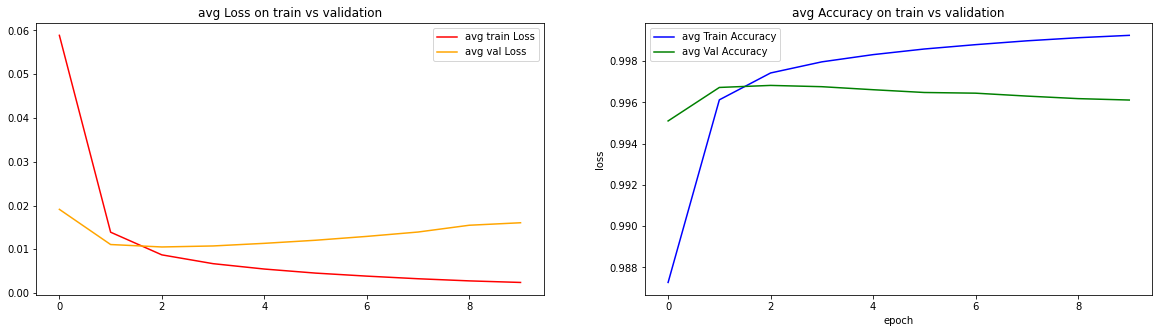

In [129]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=epochs, y=avg_losses, color='red', label='avg train Loss')
sns.lineplot(x=epochs, y=avg_val_losses, color='orange', label='avg val Loss')
plt.title('avg Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=epochs, y=avg_accuracies, color='blue', label='avg Train Accuracy')
sns.lineplot(x=epochs, y=avg_val_accuracies, color='green', label='avg Val Accuracy')
plt.title('avg Accuracy on train vs validation')
plt.legend(loc='best')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [123]:
# example how to generate plots one at a time using relplot
#sns.relplot(x="epoch", y="loss", kind="line", color='orange', ci="sd", data=losses_df);
#sns.relplot(x="epoch", y="loss", kind="line", color='red', ci="sd", data=val_losses_df);

Example plots with average and standard deviation

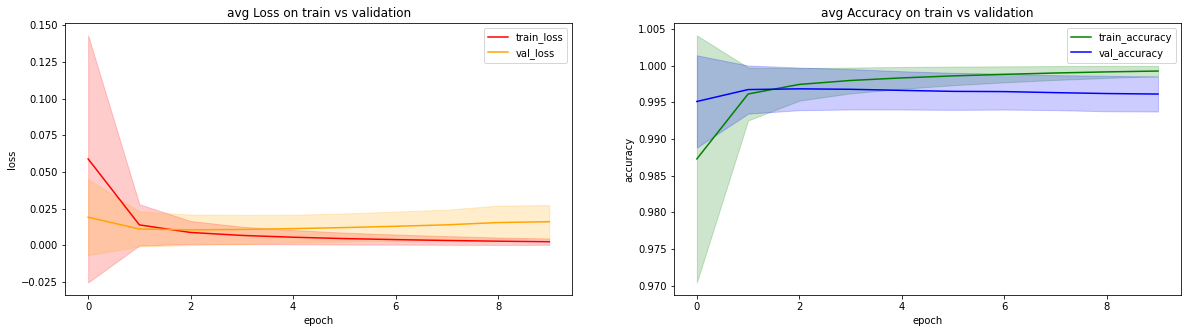

In [136]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.lineplot(x="epoch", y="loss", color='red', ci="sd", data=losses_df,  label='train_loss');
sns.lineplot(x="epoch", y="loss", color='orange', ci="sd", data=val_losses_df,  label='val_loss');
plt.title('avg Loss on train vs validation')
plt.legend(loc='best')

plt.subplot(1,2,2)
sns.lineplot(x="epoch", y="accuracy", color='green', ci="sd", data=accuracies_df,  label='train_accuracy');
sns.lineplot(x="epoch", y="accuracy", color='blue', ci="sd", data=val_accuracies_df,  label='val_accuracy');
plt.title('avg Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

## Final Training

Train on entire training set and test on test set

In [148]:
with tf.device(device_spec):
    finalmodel = getModel(32, vocab_size, max_len, num_tags)
    print(finalmodel.summary())
    history = finalmodel.fit(np.array(x_train), np.array(y_train), batch_size=32, epochs=10, validation_data=(np.array(x_test), np.array(y_test)), verbose=1)        

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 64)           2251520   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 128)          66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 18)           2322      
Total params: 2,319,890
Trainable params: 2,319,890
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1199/1199 [==============================] - 123s 101ms/step - loss: 0.2930 - accuracy: 0.9473 - val_loss: 0.0340 - val_accuracy: 0.9913
Epoch 2/10
1199/1199 [==============================] - 124s 103ms/step - loss: 0.0277 - 

## Evaluation

In [154]:
# get predictions

y_pred = finalmodel.predict(x_test)


In [191]:
# converts model predictions to the labels

# `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* 
# `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

def pred2label(predictions):
    result = []
    for prediction in predictions:
        tags = []
        for p in prediction:
            p = np.argmax(p, axis=-1)
            tags.append(idx2tag[p].replace("PAD_TAG", "O"))
        result.append(tags)
    return result

In [192]:
pred_labels = pred2label(y_pred)
test_labels = []
for i in y_test:
    tags = []
    for id in i:
        tags.append(idx2tag[id].replace("PAD_TAG", "O"))
    test_labels.append(tags)
                    

In [193]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 79.9%


In [194]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         art       0.20      0.08      0.11        91
         eve       0.38      0.35      0.37        65
         geo       0.83      0.85      0.84      7584
         gpe       0.95      0.93      0.94      3195
         nat       0.47      0.40      0.44        47
         org       0.64      0.67      0.65      4036
         per       0.74      0.72      0.73      3403
         tim       0.82      0.84      0.83      4149

   micro avg       0.79      0.80      0.80     22570
   macro avg       0.63      0.61      0.61     22570
weighted avg       0.79      0.80      0.80     22570



### Checking prediction for a sentence

In [199]:
testwords = []
for i in x_test[0]:
    testwords.append(idx2word[i])

In [200]:
testwords

['Two',
 'federal',
 'policemen',
 'walk',
 'past',
 'crosses',
 'standing',
 'where',
 'eight',
 'women',
 'were',
 'found',
 'sexually',
 'assaulted',
 'and',
 'murdered',
 'in',
 '2001',
 'in',
 'Ciudad',
 'Juarez',
 'Mexican',
 'authorities',
 'say',
 'one',
 'woman',
 'has',
 'been',
 'murdered',
 'and',
 'another',
 'raped',
 'in',
 'a',
 'city',
 'on',
 'the',
 'U.S.',
 'border',
 'known',
 'for',
 'hundreds',
 'of',
 'violent',
 'crimes',
 'against',
 'women',
 'for',
 'more',
 'than',
 'a',
 'decade',
 '.',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 'PAD_TOKEN',
 '

In [201]:
zipped = zip(testwords, pred_labels[0])

In [202]:
for i in zipped:
    print(i)

('Two', 'O')
('federal', 'O')
('policemen', 'O')
('walk', 'O')
('past', 'O')
('crosses', 'I-tim')
('standing', 'O')
('where', 'O')
('eight', 'O')
('women', 'O')
('were', 'O')
('found', 'O')
('sexually', 'O')
('assaulted', 'O')
('and', 'O')
('murdered', 'O')
('in', 'O')
('2001', 'B-tim')
('in', 'O')
('Ciudad', 'B-geo')
('Juarez', 'I-geo')
('Mexican', 'B-gpe')
('authorities', 'O')
('say', 'O')
('one', 'O')
('woman', 'O')
('has', 'O')
('been', 'O')
('murdered', 'O')
('and', 'O')
('another', 'O')
('raped', 'O')
('in', 'O')
('a', 'O')
('city', 'O')
('on', 'O')
('the', 'O')
('U.S.', 'B-geo')
('border', 'O')
('known', 'O')
('for', 'O')
('hundreds', 'O')
('of', 'O')
('violent', 'O')
('crimes', 'O')
('against', 'O')
('women', 'O')
('for', 'O')
('more', 'O')
('than', 'O')
('a', 'O')
('decade', 'O')
('.', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')
('PAD_TOKEN', 'O')